In [189]:
from pydantic import BaseModel, root_validator, model_validator
from typing import List
import matplotlib.pyplot as plt
import json
from random import randint
from enum import Enum
import numpy as np
from matplotlib.patches import RegularPolygon
from perlin_noise import PerlinNoise

In [205]:
from os import listdir


In [215]:
for file_name in listdir("data/games"):
    print(file_name[:-5])

000


In [213]:
e = 40
f""

'040'

In [190]:

class CellType(Enum):
    mauntain = "mauntain"
    plain = "plain"
    see = "see"
    empty = "empty"
    hills = "hills"
    city = "city"


class Cell(BaseModel):
    type: CellType
    yields: int


In [191]:
class Dice(BaseModel):
    dice_size: int

    def roll(self) -> int:
        r = randint(1, self.dice_size)
        print.info(f"dice of size {self.dice_size} rolled {r}")
        return r

    def expected(self) -> float:
        return (self.dice_size + 1) / 2

    def __eq__(self, __value: object) -> bool:
        assert isinstance(__value, Dice)
        return self.dice_size == __value.dice_size


class DiceSet(BaseModel):
    dices: List[Dice]

    def roll(self) -> int:
        out = 0
        for dice in self.dices:
            out += dice.roll()
        return out

    def expected(self) -> float:
        out = 0.0
        for dice in self.dices:
            out += dice.expected()
        return out

    def __eq__(self, __value: object) -> bool:
        assert isinstance(__value, DiceSet)
        return self.dices == __value.dices

    @property
    def is_zero(self):
        return len(self.dices) == 0

    @staticmethod
    def from_dice_code(dice_code: str):
        dices = []
        if dice_code == "":
            return DiceSet(dices=[])
        dices_str = dice_code.split(" ")
        for dice in dices_str:
            n_dice_str, dice_size_str = dice.split("d")
            n_dice = 1 if n_dice_str == "" else int(n_dice_str)
            dice_size = int(dice_size_str)
            for _ in range(n_dice):
                dices.append(Dice(dice_size=dice_size))
        return DiceSet(dices=dices)


In [192]:
class HexCoord(BaseModel):
    q: int
    r: int
    s: int
    @model_validator(mode="after")
    def valid_params(self):
        assert self.q + self.r + self.s == 0

    def distance(self, to: 'HexCoord') -> int:
        return max([
            abs(self.q - to.q),
            abs(self.r - to.r),
            abs(self.s - to.s)
        ])

class HexBoard(BaseModel):
    raw_board: List[List[Cell]]

    @staticmethod
    def build_circular(radius: int, octaves: float = 3, thresholds: List = [-.1,0,.2]) -> "HexBoard":
        side_size = (2 * radius) + 1

        noise = PerlinNoise(octaves=octaves)
        pic = np.array([[noise([i/10, j/10]) for j in range(side_size)] for i in range(side_size)])
        idx_board = np.digitize(pic, thresholds, right=True)

        cells_type = [CellType.see, CellType.plain, CellType.hills, CellType.mauntain]

        cell_board = [[Cell(type=cells_type[idx], yields=1) for idx in row] for row in idx_board]
        for row in range(radius):
            for i in range(radius - row):
                cell_board[row][i] = Cell(type=CellType.empty, yields=0)
                cell_board[side_size -1 -row][side_size -1 -i] = Cell(type=CellType.empty, yields=0)
        

        return HexBoard(raw_board=cell_board)

In [202]:
class UnitType(Enum):
    warrior = "warrior"
    archer = "archer"
    knight = "knight"
    defender = "defender"
    catapult = "catapult"


stats_dict = json.load(open("src/game_logic/units_stats.json"))


class UnitStats(BaseModel):
    type: UnitType
    cost: int
    attack_melee: DiceSet
    attack_ranged: DiceSet
    defense: DiceSet
    movement: int
    range: int

    @staticmethod
    def from_type(type: UnitType) -> "UnitStats":
        return UnitStats(
            type=type,
            cost=stats_dict[type.value]["cost"],
            attack_melee=DiceSet.from_dice_code(
                stats_dict[type.value]["attack_melee"]
            ),
            attack_ranged=DiceSet.from_dice_code(
                stats_dict[type.value]["attack_ranged"]
            ),
            defense=DiceSet.from_dice_code(stats_dict[type.value]["defense"]),
            movement=stats_dict[type.value]["movement"],
            range=stats_dict[type.value]["range"],
        )

    def __eq__(self, __value: object) -> bool:
        assert isinstance(__value, UnitStats)
        if self.type != __value.type:
            return False
        assert self.cost == __value.cost
        assert self.attack_melee == __value.attack_melee
        assert self.attack_ranged == __value.attack_ranged
        assert self.defense == __value.defense
        assert self.movement == __value.movement
        assert self.range == __value.range
        return True


class Unit(BaseModel):
    loc: HexBoard
    owner_id: int
    id: int
    type: UnitType
    actions: int

    def __eq__(self, __value: object) -> bool:
        assert isinstance(__value, Unit)
        if self.id != __value.id:
            return False
        assert self.location == __value.location
        assert self.owner_id == __value.owner_id
        assert self.stats == __value.stats
        assert self.actions == __value.actions
        return True

    def reset_upkeep(self):
        self.actions = self.stats.movement

    @property
    def stats(self) -> UnitStats:
        return UnitStats.from_type(self.type)

    def move_to(self, to: HexCoord, board: HexBoard) -> None:
        if self.location.distance(to) > self.actions:
            raise ValueError(
                f"Unit {self.id} cannot move: only {self.actions} actions left"
            )
        # TODO: add physics, now can move on see or through mountains
        self.actions -= self.location.distance(to)
        self.location = to


In [203]:
HexBoard.build_circular(3)

HexBoard(raw_board=[[Cell(type=<CellType.empty: 'empty'>, yields=0), Cell(type=<CellType.empty: 'empty'>, yields=0), Cell(type=<CellType.empty: 'empty'>, yields=0), Cell(type=<CellType.plain: 'plain'>, yields=1), Cell(type=<CellType.hills: 'hills'>, yields=1), Cell(type=<CellType.hills: 'hills'>, yields=1), Cell(type=<CellType.plain: 'plain'>, yields=1)], [Cell(type=<CellType.empty: 'empty'>, yields=0), Cell(type=<CellType.empty: 'empty'>, yields=0), Cell(type=<CellType.hills: 'hills'>, yields=1), Cell(type=<CellType.hills: 'hills'>, yields=1), Cell(type=<CellType.mauntain: 'mauntain'>, yields=1), Cell(type=<CellType.hills: 'hills'>, yields=1), Cell(type=<CellType.hills: 'hills'>, yields=1)], [Cell(type=<CellType.empty: 'empty'>, yields=0), Cell(type=<CellType.mauntain: 'mauntain'>, yields=1), Cell(type=<CellType.hills: 'hills'>, yields=1), Cell(type=<CellType.plain: 'plain'>, yields=1), Cell(type=<CellType.hills: 'hills'>, yields=1), Cell(type=<CellType.hills: 'hills'>, yields=1), Cel

In [204]:
Unit(loc=HexBoard.build_circular(3), owner_id=0, id=0, type=UnitType.archer, actions=0)

Unit(loc=HexBoard(raw_board=[[Cell(type=<CellType.empty: 'empty'>, yields=0), Cell(type=<CellType.empty: 'empty'>, yields=0), Cell(type=<CellType.empty: 'empty'>, yields=0), Cell(type=<CellType.plain: 'plain'>, yields=1), Cell(type=<CellType.hills: 'hills'>, yields=1), Cell(type=<CellType.hills: 'hills'>, yields=1), Cell(type=<CellType.hills: 'hills'>, yields=1)], [Cell(type=<CellType.empty: 'empty'>, yields=0), Cell(type=<CellType.empty: 'empty'>, yields=0), Cell(type=<CellType.see: 'see'>, yields=1), Cell(type=<CellType.see: 'see'>, yields=1), Cell(type=<CellType.see: 'see'>, yields=1), Cell(type=<CellType.plain: 'plain'>, yields=1), Cell(type=<CellType.hills: 'hills'>, yields=1)], [Cell(type=<CellType.empty: 'empty'>, yields=0), Cell(type=<CellType.see: 'see'>, yields=1), Cell(type=<CellType.see: 'see'>, yields=1), Cell(type=<CellType.see: 'see'>, yields=1), Cell(type=<CellType.see: 'see'>, yields=1), Cell(type=<CellType.hills: 'hills'>, yields=1), Cell(type=<CellType.hills: 'hills'

In [199]:
HexCoord(q=0, r=0, s=0)

HexCoord(q=0, r=0, s=0)

In [179]:
board = HexBoard.build_circular(7)

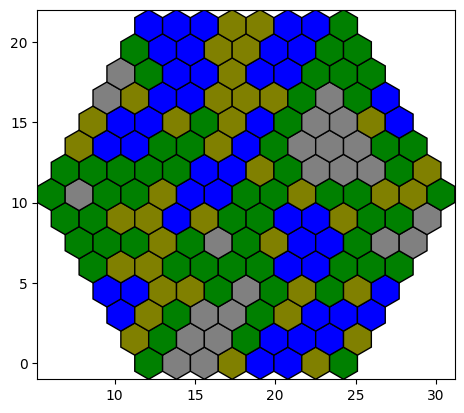

In [180]:
fig, ax = plt.subplots(1)
colors = {
    CellType.see: "blue", CellType.plain: "olive", CellType.hills: "green", CellType.mauntain: "gray", CellType.empty: "black"
}
hxs = []
max_x = 0
max_y = 0
min_x = 1000
min_y = 1000
for i, row in enumerate(board.raw_board):
    for j, cell in enumerate(row):
        y = i*(1.5)
        x = j*np.sqrt(3) + i*(np.sqrt(3)/2)
        if cell.type != CellType.empty:
            hxs.append(RegularPolygon((x, y), numVertices=6, radius=1, 
                                orientation=np.radians(0), 
                                facecolor=colors[cell.type], alpha=1, edgecolor='k'))
            max_x=max(x,max_x)
            max_y=max(y,max_y)
            min_x=min(x,min_x)
            min_y=min(y,min_y)

for hex in hxs:
    ax.add_patch(hex)
S= 25
ax.set_xlim([-np.sqrt(3)/2 + min_x, max_x + np.sqrt(3)/2])
ax.set_ylim([-1+ min_y, max_y + 1])
ax.set_aspect('equal')


In [165]:
a = [[5,10],[11,14],[21,22],[16,19],[21,25],[6,18],[1,9],[4,7],[10,23],[5,14],[9,18],[18,21],[11,22],[1,15],[1,2],[5,18],[7,20],[2,23],[12,13],[9,14],[10,16],[11,21],[5,12],[2,24],[8,17],[15,17],[10,13],[11,16],[20,22],[7,11],[9,15],[16,22],[18,20],[19,22],[10,18],[3,20],[16,25],[10,15],[1,23],[13,16],[23,25],[1,8],[4,10],[19,24],[11,20],[3,18],[6,25],[11,13],[13,15],[22,24],[6,24],[17,20],[2,25],[15,24],[8,21],[14,16],[5,16],[19,23],[1,5],[4,22],[19,20],[12,15],[16,18],[9,13],[13,22],[14,22],[2,8],[3,13],[9,23],[14,15],[14,17],[8,20],[9,17],[3,19],[8,25],[2,12],[7,24],[19,25],[1,13],[6,11],[14,21],[7,15],[3,14],[15,23],[10,17],[4,20],[6,14],[10,21],[2,13],[3,21],[8,11],[5,21],[6,23],[17,25],[16,21],[12,22],[1,16],[6,19],[7,25],[3,23],[11,25],[3,10],[6,7],[2,3],[5,25],[1,6],[4,17],[2,16],[13,17],[17,22],[6,13],[5,6],[4,11],[4,23],[4,8],[12,23],[7,21],[5,20],[3,24],[2,10],[13,14],[11,24],[1,3],[2,7],[7,23],[6,17],[5,17],[16,17],[8,15],[8,23],[7,17],[14,18],[16,23],[23,24],[4,12],[17,19],[5,9],[10,11],[5,23],[2,9],[1,19],[2,19],[12,20],[2,14],[11,12],[1,12],[13,23],[4,9],[7,13],[15,20],[21,24],[8,18],[9,11],[8,19],[6,22],[16,20],[22,25],[20,21],[6,16],[3,17],[1,22],[9,22],[20,24],[2,6],[9,16],[2,4],[2,20],[20,25],[9,10],[3,11],[15,18],[1,20],[3,6],[8,14],[10,22],[12,21],[7,8],[8,16],[9,20],[3,8],[15,21],[17,21],[11,18],[13,24],[17,24],[6,20],[4,15],[6,15],[3,22],[13,21],[2,22],[13,25],[9,12],[4,19],[1,24],[12,19],[5,8],[1,7],[3,16],[3,5],[12,24],[3,12],[2,17],[18,22],[4,25],[8,24],[15,19],[18,23],[1,4],[1,21],[10,24],[20,23],[4,14],[16,24],[10,20],[18,24],[1,14],[12,14],[10,12],[4,16],[5,19],[4,5],[19,21],[15,25],[1,18],[2,21],[4,24],[7,14],[4,6],[15,16],[3,7],[21,23],[1,17],[12,16],[13,18],[5,7],[9,19],[2,15],[22,23],[7,19],[17,23],[8,22],[11,17],[7,16],[8,9],[6,21],[4,21],[4,13],[14,24],[3,4],[7,18],[11,15],[5,11],[12,17],[6,9],[1,25],[12,18],[6,12],[8,10],[6,8],[11,23],[7,10],[14,25],[14,23],[12,25],[5,24],[10,19],[3,25],[7,9],[8,12],[5,22],[24,25],[13,19],[3,15],[5,15],[15,22],[10,14],[3,9],[13,20],[1,10],[9,21],[10,25],[9,24],[14,20],[9,25],[8,13],[7,12],[5,13],[6,10],[2,5],[2,18],[14,19],[1,11],[7,22],[18,25],[11,19],[18,19],[4,18],[17,18],[2,11]]

In [8]:
for row in a:
    if row[1] == 3:
        print(row)

[2, 3]
[1, 3]


In [9]:
for row in a:
    if row[1] == 1:
        print(row)

In [6]:
a

[[1, 2, 3, 2, 2, 2, 1, 1, 0, 2],
 [2, 1, 1, 4, 3, 3, 4, 2, 4, 3],
 [0, 4, 4, 4, 2, 0, 3, 0, 3, 0],
 [4, 1, 3, 4, 2, 2, 3, 3, 2, 1],
 [4, 3, 0, 2, 2, 0, 2, 4, 2, 3],
 [1, 1, 2, 2, 0, 3, 0, 4, 2, 1],
 [0, 0, 0, 0, 4, 3, 4, 0, 1, 4]]

In [8]:
Unit(
    location=Coord(row=0, col=0), owner_id=1, id=0, type=UnitType.warrior, actions=0)

Unit(location=Coord(row=0, col=0), owner_id=1, id=0, type=<UnitType.warrior: 'warrior'>, actions=0)

In [12]:
class ActionType(Enum):
    move_unit = "move_unit"
    attack = "attack"
    build_unit = "build_unit"
    end_turn = "end_turn"


class ActionParam(BaseModel):
    game_id: int
    player_id: int
    class Config:
        extra = "forbid"


class ActionParamMoveUnit(ActionParam):
    unit_id: int
    move_to: Coord


class ActionParamAttack(ActionParam):
    attacking_unit_ids: List[int]
    attacked_unit_id: int


class ActionParamBuildUnit(ActionParam):
    location: Coord
    type: UnitType


class ActionParamEndTurn(ActionParam):
    pass


class Action(BaseModel):
    action_type: ActionType
    params: Union[ActionParamMoveUnit, ActionParamAttack, ActionParamBuildUnit, ActionParamEndTurn]
    
    @field_validator("params", mode="after")
    def valid_params(cls, v,  values):
        if values.data["action_type"] == ActionType.move_unit:
            assert isinstance(v, ActionParamMoveUnit)
        elif values.data["action_type"] == ActionType.attack:
            assert isinstance(v, ActionParamAttack)
        elif values.data["action_type"] == ActionType.build_unit:
            assert isinstance(v, ActionParamBuildUnit)
        elif values.data["action_type"] == ActionType.end_turn:
            assert isinstance(v, ActionParamEndTurn)

In [2]:
a = "hello"
a[:100]

'hello'

In [13]:
data = {
    "action_type" : "move_unit",
    "params": {
        "game_id" : 0,
        'player_id': 1,
        "unit_id":0,
        "move_to":{
            "row":0,
            "col":0,
        }
    }
}
data2 = {
    "action_type" : "attack",
    "params": {
        "game_id" : 0,
        'player_id': 1,
        "attacking_unit_ids":[0,1,2],
        "attacked_unit_id":3
    }
}
data3 = {
    "action_type" : "build_unit",
    "params": {
        "game_id" : 0,
        'player_id': 1,
        "location":{
            "row":0,
            "col":0,
        },
        "type":"warrior"
    }
}
data4 = {
    "action_type" : "end_turn",
    "params": {
        "game_id" : 0,
        'player_id': 1
    }
}
print(data3)
a = [Action.model_validate(d) for d in [data, data2, data3, data4]]
print(a)

{'action_type': 'build_unit', 'params': {'game_id': 0, 'player_id': 1, 'location': {'row': 0, 'col': 0}, 'type': 'warrior'}}
[Action(action_type=<ActionType.move_unit: 'move_unit'>, params=None), Action(action_type=<ActionType.attack: 'attack'>, params=None), Action(action_type=<ActionType.build_unit: 'build_unit'>, params=None), Action(action_type=<ActionType.end_turn: 'end_turn'>, params=None)]


In [10]:
ActionParam(**data3["params"])

ValidationError: 2 validation errors for ActionParam
location
  Extra inputs are not permitted [type=extra_forbidden, input_value={'row': 0, 'col': 0}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.0.1/v/extra_forbidden
type
  Extra inputs are not permitted [type=extra_forbidden, input_value='warrior', input_type=str]
    For further information visit https://errors.pydantic.dev/2.0.1/v/extra_forbidden

In [7]:
data3["params"]

{'game_id': 0,
 'player_id': 1,
 'location': {'row': 0, 'col': 0},
 'type': 'warrior'}